# Creating a General Purpose Potential for Molecular Crystals - Part 5

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D3 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- Create a model using fewer structures (maybe 150 or so) but many more confidgurations per structure (maybe 50 or so)
- Hopefully force prediction will be more accurate if more configurational dependence information is provided
- This also requires the crystals to be FPS sorted, to recreate a test set (or maybe two - one containing new configurations of crystals in the training dataset, and one containing configurations of crystals outside of the training dataset - the latter being the real test)


- Firstly, we must figure out how many "meaningful" configurations there are per crystal, by donig PCovFPS sorting and looking at the FPS distance

## Create model using 150 configurations per structure

## Import modules, define functions and SOAP

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS, PCovFPS, PCovCUR
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [2]:
#Import entire dataset
with open('raw_data/CSD-10k_combined_w_kpts.pickle', 'rb') as csd_file:
    db = pickle.load(csd_file)
name=list(db.keys())

In [3]:
#Wrap all cells
for struct in name:
    for frm in db[struct]:
        frm.wrap(eps = 1e-14)

In [4]:
#Import total dressed atom model
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.1.0rc1 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array('forces') 
        iat += len(frm)
    return frc

#Get feature vectors for a list of atoms objects. This requires soap to be set, as well as all_species, which is
#a list with one atoms object that contains all species HCNO
def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

In [6]:
#Define soap hyperparameters
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=2
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)


## PCovFPS sort configurations of a single structure

In [7]:
selector = PCovFPS(mixing = 0.3, n_to_select = 100, progress_bar=False)

In [8]:
for struct in name[:20]:
    energies = []
    ats = np.zeros((len(db[struct]), 4))
    feat_length = soap.transform(db[struct][0]).get_features(soap).shape[1]
    feats = np.zeros((len(db[struct]), int(feat_length)))
    for ifrm, frm in enumerate(db[struct]):
        frm.wrap()
        atnos = frm.get_atomic_numbers()
        ats[ifrm] = [len(np.where(atnos == sp)[0]) for sp in [1,6,7,8]]
        energies.append(frm.info['energy'])
        feats[ifrm] = np.mean(soap.transform(frm).get_features(soap), axis=0)
    dressed_energies = mlr.predict(ats)
    y_configs = energies - dressed_energies

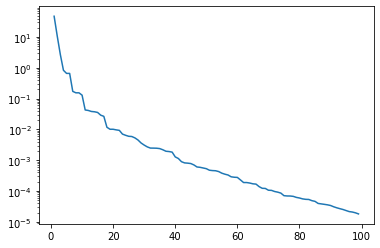

In [9]:
selector.fit(feats, y_configs)
plt.plot(selector.get_select_distance()[:100])
plt.yscale('log')

Rose said that between 10e-3 and 10e-4 is a good threshold for PCovFPS, and so I'll use 60 frames per structure for the model

## PCovFPS sort one configuration of all structures

In [10]:
selector = PCovFPS(mixing = 0.3, n_to_select = len(db)-1, progress_bar=False)

In [11]:
crystals = []
for struct in name:
    crystals.append(db[struct][0])
energies = []
ats = np.zeros((len(crystals), 4))
for ifrm, frm in enumerate(crystals):
    atnos = frm.get_atomic_numbers()
    ats[ifrm] = [len(np.where(atnos == sp)[0]) for sp in [1,6,7,8]]
    energies.append(frm.info['energy'])
dressed_energies = mlr.predict(ats)
y_crystals = energies - dressed_energies
crystal_feats = get_features(crystals)

  0%|          | 0/3 [00:00<?, ?it/s]

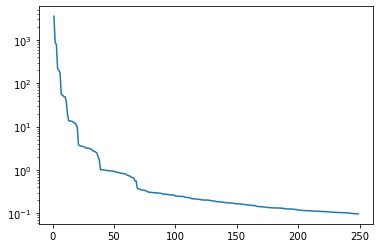

In [13]:
selector = PCovFPS(mixing = 0.3, n_to_select = len(crystals)-1, progress_bar=False)
selector.fit(crystal_feats, y_crystals)
plt.plot(selector.get_select_distance()[0:250])
plt.yscale('log')

Although there's definitely more info to be gained from adding more strucutres, it seems like using 150 structures is a good compromise between accuracy and number of structures, so I will use that amount.

## Creating training, validation, and test sets

Validation set will be created using configurations from the same crystal, whereas the test set will be created using new configurations

In [14]:
#PCovFPS select crystals to use
#Note that the 'crystals' list is in the order of the 'name' list
fps_order = []
for feat in tqdm(selector.X_selected_):
    for istruct, struct in enumerate(crystal_feats):
        if np.array_equal(struct, feat) == True:
            fps_order.append(istruct)

  0%|          | 0/2237 [00:00<?, ?it/s]

In [65]:
#Create the training database
db_train = {}
db_val = {}
db_test = {}
train_ids = {}
train_set = []

selector = PCovFPS(mixing = 0.3, n_to_select = 100, progress_bar=False)
for struct in tqdm(fps_order[:150]):
    crystal_name = name[struct]
    energies = []
    ats = np.zeros((len(db[crystal_name]), 4))
    feat_length = soap.transform(db[crystal_name][0]).get_features(soap).shape[1]
    feats = np.zeros((len(db[crystal_name]), int(feat_length)))
    for ifrm, frm in enumerate(db[crystal_name]):
        frm.wrap()
        atnos = frm.get_atomic_numbers()
        ats[ifrm] = [len(np.where(atnos == sp)[0]) for sp in [1,6,7,8]]
        energies.append(frm.info['energy'])
        feats[ifrm] = np.mean(soap.transform(frm).get_features(soap), axis=0)
    dressed_energies = mlr.predict(ats)
    y_configs = energies - dressed_energies
    selector.fit(feats, y_configs)
    frames_selected = []
    ids_selected = []
    for sel_feats in selector.X_selected_[:60]:
        for ift, ft in enumerate(feats):
            if np.array_equal(sel_feats, ft) == True:
                frames_selected.append(db[crystal_name][ift])
                train_set.append(db[crystal_name][ift])
                ids_selected.append(ift)
    db_train[crystal_name] = frames_selected
    train_ids[crystal_name] = ids_selected

#Save train database and train set
with open('raw_data/high_config_potential/CSD-10k_train_db.pickle', "wb") as r:
    pickle.dump(db_train, r)
r.close()

np.save('raw_data/high_config_potential/CSD-10k_train_set', np.asarray(train_set, dtype='object'))

  0%|          | 0/150 [00:00<?, ?it/s]

In [68]:
#Create preliminary val set containing ids of all strctures whose crystals are in the training set, 
# but whose specific configurations are not
val_ids_all = {}
val_structs_all = []
for na in name:
    if na in train_ids.keys():
        val_ids = []
        for i in range(0,101,1):
            if i not in train_ids[na]:
                val_ids.append(i)
                val_structs_all.append(db[na][i])
        val_ids_all[na] = val_ids

In [69]:
#Create preliminary test set containing all configurations of crystals not in the training set
# This just gets the name of the structures not in the training (and validation) set
test_names = []
test_structs_all = []
for na in name:
    if na not in train_ids.keys():
        test_names.append(na)
        test_structs_all.extend(db[na])

In [70]:
#Create true validation and test sets, each of size 1000
#Validation set:
val_ids = np.arange(len(val_structs_all))
np.random.seed(10)
np.random.shuffle(val_ids)

val_set = []
for i in val_ids[:1000]: 
    val_set.append(val_structs_all[i])

#Test set:
test_ids = np.arange(len(test_structs_all))
np.random.seed(20)
np.random.shuffle(test_ids)

test_set = []
for i in test_ids[:1000]: 
    test_set.append(test_structs_all[i])
    
np.save('raw_data/high_config_potential/CSD-10k_val_set', np.asarray(val_set, dtype='object'))
np.save('raw_data/high_config_potential/CSD-10k_test_set', np.asarray(test_set, dtype='object'))

In [8]:
#(Re-)Load databases
train_set = np.load('raw_data/high_config_potential/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/high_config_potential/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/high_config_potential/CSD-10k_test_set.npy', allow_pickle=True)

## Create dressed atom energies model (i.e. baseline)
A simple dressed atom model (baseline) is created. This is done so that the "atomic" energies are not learned, but rather the "binding energies" of each crystal is learned. 

In [71]:
#Create a matrix of n_structures x n_atoms_per_species (i.e. 2238 x 4 matrix), and a vectors with energies of structures
db_all = []
[db_all.extend(db[n]) for n in db]

X_all = np.zeros((len(db_all),4),dtype=int) #create matrix
y_all = np.zeros(len(db_all)) #create vector
for ifrm, frm in enumerate(db_all):
    symbols=frm.get_atomic_numbers() #get atomic numbers from frame
    y_all[ifrm]=(frm.info['energy']) #get energy from frame
    X_all[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]] #create vector of [n_H, n_C, n_N, n_O] and add to matrix

np.save('raw_data/high_config_potential/X_all', X_all) #Save matrix
np.save('raw_data/high_config_potential/y_all', y_all) #Save vector

In [72]:
#Create same as above but for train set
X_train = np.zeros((len(train_set),4),dtype=int)
y_train = np.zeros(len(train_set))
for ifrm, frm in enumerate(train_set):
    symbols=frm.get_atomic_numbers()
    y_train[ifrm]=(frm.info['energy'])
    X_train[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

np.save('raw_data/high_config_potential/X_train', X_train) #Save matrix
np.save('raw_data/high_config_potential/y_train', y_train) #Save vector

In [73]:
#Create same as above but for validation set
X_val = np.zeros((len(val_set),4),dtype=int)
y_val = np.zeros(len(val_set))
for ifrm, frm in enumerate(val_set):
    symbols=frm.get_atomic_numbers()
    y_val[ifrm]=(frm.info['energy'])
    X_val[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

np.save('raw_data/high_config_potential/X_val', X_val) #Save matrix
np.save('raw_data/high_config_potential/y_val', y_val) #Save vector

In [74]:
#Create same as above but for test set
X_test = np.zeros((len(test_set),4),dtype=int)
y_test = np.zeros(len(test_set))
for ifrm, frm in enumerate(test_set):
    symbols=frm.get_atomic_numbers()
    y_test[ifrm]=(frm.info['energy'])
    X_test[ifrm]=[len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]

np.save('raw_data/high_config_potential/X_test', X_test) #Save matrix
np.save('raw_data/high_config_potential/y_test', y_test) #Save vector

In [9]:
#(Re)Load Xs and ys for train, val, test sets
X_all = np.load('raw_data/high_config_potential/X_all.npy')
y_all = np.load('raw_data/high_config_potential/y_all.npy')

X_train = np.load('raw_data/high_config_potential/X_train.npy')
y_train = np.load('raw_data/high_config_potential/y_train.npy')

X_val = np.load('raw_data/high_config_potential/X_val.npy')
y_val = np.load('raw_data/high_config_potential/y_val.npy')

X_test = np.load('raw_data/high_config_potential/X_test.npy')
y_test = np.load('raw_data/high_config_potential/y_test.npy')

### Create model

In [16]:
#Create a simple model in order to baseline energies (i.e. get a model that predicts per-atom-per-species energies)
# This is done so that the MLP that will be created is centred around zero and independent of system size
mlr = Ridge(alpha=1E-4, fit_intercept=False) #Don't fit intercept
mlr.fit(X_all, y_all)
print("Intercept: ", mlr.intercept_)
print("Coefficients:",mlr.coef_)

Intercept:  0.0
Coefficients: [ -16.46576331 -154.71870284 -383.3436899  -566.22750974]


In [17]:
#Save model
with open('raw_data/high_config_potential/mlr.pkl','wb') as f:
    pickle.dump(mlr, f)

In [10]:
#Load model
with open('raw_data/high_config_potential/mlr.pkl', 'rb') as f:
    mlr = pickle.load(f)

### Get reduced atom energies for train, validation, test sets

In [11]:
yred_train = y_train/np.sum(X_train,axis=1)-mlr.predict(X_train)/np.sum(X_train,axis=1)#Baselined per-atom binding energies of training set
yred_val = y_val/np.sum(X_val,axis=1)-mlr.predict(X_val)/np.sum(X_val,axis=1) #Baselined per-atom binding energies of validation set
yred_test = y_test/np.sum(X_test, axis=1)-mlr.predict(X_test)/np.sum(X_test,axis=1)#Baselined per-atom binding energies of test set

## Loop for hyperparameter optimisation
Loop for optimisaing SOAP hyperparameters, as well as zeta and regularization constants. This loop can take several hours, and so the results have been saved and can be reloaded below. 

In [23]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=4, #cutoff distance in angstroms
              max_radial=6, #no. of radial basis functions
              max_angular=4, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

### Self-consistent loop

In [ ]:
results=[]
count=1; 
    
#Iterate over scale
for scale in [2.,2.5,3.]:
    hypers['cutoff_function_parameters']['scale']=scale

    #Iterate over exponent
    for exp in [0.,1.,2.,4.]:
        start = time()
        hypers['cutoff_function_parameters']['exponent']=exp
        soap = SphericalInvariants(**hypers) #redefine soap with new parameters
        print("Iteration: ", count, "/ 12") #keep count of iteration
        train_feat=get_features(train_set, progress_bar=False) #get features for training set
        test_feat=get_features(test_set, progress_bar=False) #get features for validation set
        count+=1

        #Iterate over zeta values
        for zeta in [2.,3.]:
            K = np.dot(train_feat,train_feat.T)**zeta #compute covariance matrix for training
            Ktest = np.dot(test_feat,train_feat.T)**zeta #compute covariance matrix for testing

            #Iterate over regularization values
            minerr = 1e24 ; minreg = 0
            for reg in np.logspace(-9,-5,5):
                KRR = KernelRidge(kernel='precomputed',alpha = reg)
                KRR.fit(K,yred_train)
                err = np.std(yred_test - KRR.predict(Ktest))
                if err < minerr:
                    minerr = err.copy()
                    minreg = reg.copy()
            print("")
            print('Created model using the following parameters:')
            print('Scale:', scale, ' Exponent:', exp, ' Zeta:', zeta, '(Minimum) Regulariser:', minreg)
            print('Error corresponding to this model:', np.round(minerr, 8), 'eV')
            print("")
            results.append([minerr, scale, exp, zeta, minreg])

        print('time',time()-start)
        print("")

### Save and (re-)load hyperparameter optimisation results

In [30]:
np.save('raw_data/high_config_potential/hyperparam_optimisation_results_no_normalisation', np.asarray(results))

In [31]:
hyperopt=np.load('raw_data/high_config_potential/hyperparam_optimisation_results_no_normalisation.npy')

In [41]:
# Find optimal hyperparameters, which correspond to the lowest error
print("Results in order of Minimum error, scale, exponent, zeta, and regulariser")
print(hyperopt[np.where(hyperopt==np.amin(hyperopt, axis=0)[0])[0][0]])

Results in order of Minimum error, scale, exponent, zeta, and regulariser
[4.84991569e-02 2.00000000e+00 4.00000000e+00 2.00000000e+00
 1.00000000e-05]


Optimal parameters for the Kernel model are:
- Scale: 2.0
- Exponent: 4.0
- Zeta: 2.0
- Regulariser: 1e-5

## Create model

In [24]:
#Define hyperparameters and SOAP
zeta = 2
hypers["compute_gradients"] = False
soap = SphericalInvariants(**hypers)

In [45]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(train_set) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  49.79210186004639 s


In [46]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2500
nc = 2500
nn = 2500
no = 2500
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  346.00007581710815 s


In [48]:
dump_obj('raw_data/high_config_potential/X_sparse.json', X_sparse)

In [14]:
X_sparse = load_obj('raw_data/high_config_potential/X_sparse.json')

In [25]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [26]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(train_set, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/9000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Time taken:  82155.37623381615 s


In [27]:
#Save kernel
np.save('raw_data/high_config_potential/Knm_kernel', Knm)

In [15]:
start = time()
print("Loading Knm...")
Knm = np.load('raw_data/high_config_potential/Knm_kernel.npy')
print("Knm loading time:", time()-start)

Loading Knm...
Knm loading time: 1779.0270457267761


In [28]:
#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

In [29]:
#Train GAP model
print("Training GAP model...")
start = time()
model = train_gap_model(kernel, train_set, Knm, X_sparse, y_train, y_dressed, 
                        grad_train=-get_forces(train_set), lambdas=[0.01,0.1], jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 1739.152755022049


In [30]:
#Save model
dump_obj('raw_data/high_config_potential/GAP_model_0.01_0.1.json', model)

In [6]:
#Reload model
model = load_obj('raw_data/high_config_potential/GAP_model_0.01_0.1.json')

In [31]:
ftt = []
for frm in test_set:
    ftt.append(frm.get_array('forces'))
f_test = np.concatenate(ftt)

In [38]:
#predict energies and forces for validation set
ytp = []
ftp = []

for ifrm, frm in enumerate(tqdm(test_set, desc = "Making predictions for test set...", leave=False)):
    manager_test = soap.transform(frm)
    ytp.append(model.predict(manager_test))
    ftp.append(model.predict_forces(manager_test))

yt_pred = np.array(ytp).flatten()
ft_pred = np.concatenate(ftp)

Making predictions for test set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
f_test.shape

(88288, 3)

In [44]:
ft_pred.shape

(88288, 3)

Text(0.5, 1.0, 'Forces (ev/$\\AA$)')

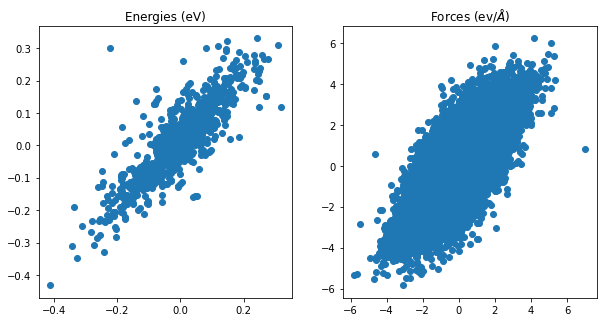

In [45]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5))
p[0].scatter((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1),
             (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))
p[0].set_title('Energies (eV)')
p[0].set()
p[1].scatter(f_test.flatten(), ft_pred.flatten())
p[1].set_title(r'Forces (ev/$\AA$)')

In [51]:
rmse_energy = np.sqrt(np.mean(((y_test - mlr.predict(X_test))/np.sum(X_test,axis=1) 
                              - (yt_pred - mlr.predict(X_test))/np.sum(X_test,axis=1))**2))

In [54]:
rmse_forces = np.sqrt(np.mean((f_test.flatten() - ft_pred.flatten())**2))

In [55]:
print(rmse_energy, rmse_forces)

0.06152550275747526 0.4870275413974186


In [56]:
np.savetxt('raw_data/high_config_potential/model_0.01_0.1_results.txt', np.array([rmse_energy, rmse_forces]))